## Aiyagari 

In [3]:
import numpy as np
from numba import jit
import quantecon as qe
import matplotlib.pyplot as plt
from quantecon.markov import DiscreteDP

In [11]:
class Household:
    """
    This class takes the parameters that define a household asset accumulation
    problem and computes the corresponding reward and transition matrices R
    and Q required to generate an instance of DiscreteDP, and thereby solve
    for the optimal policy.

    Comments on indexing: We need to enumerate the state space S as a sequence
    S = {0, ..., n}.  To this end, (a_i, z_i) index pairs are mapped to s_i
    indices according to the rule

        s_i = a_i * z_size + z_i 

    To invert this map, use
    
        a_i = s_i // z_size  (integer division)
        z_i = s_i % z_size

    """


    def __init__(self,
                 r=0.02,                      # interest rate
                 w=1.0,                       # wages
                 β=0.96,                # discount factor
                 a_min=0,
                 Π=[[0.05, 0.15, 0.2, 0.2, 0.2, 0.15,0.05],[0.05, 0.15, 0.2, 0.2, 0.2, 0.15,0.05],[0.05, 0.15, 0.2, 0.2, 0.2, 0.15,0.05],[0.05, 0.15, 0.2, 0.2, 0.2, 0.15,0.05],[0.05, 0.15, 0.2, 0.2, 0.2, 0.15,0.05],[0.05, 0.15, 0.2, 0.2, 0.2, 0.15,0.05],[0.05, 0.15, 0.2, 0.2, 0.2, 0.15,0.05]],
                 z_vals=[0.2,0.1,0.35,0.2,0.6, 0.5, 0.75],
                 a_max=20,
                 a_size=100):

        # Store values, set up grids over a and z
        self.r, self.w, self.β = r, w, β
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size

        self.Π = np.asarray(Π)
        self.z_vals = np.asarray(z_vals)
        self.z_size = len(z_vals)

        self.a_vals = np.linspace(a_min, a_max, a_size)
        self.n = a_size * self.z_size

        # Build the array Q
        self.Q = np.zeros((self.n, a_size, self.n))
        self.build_Q()

        # Build the array R
        self.R = np.empty((self.n, a_size))
        self.build_R()

    def set_prices(self, r, w):
        """
        Use this method to reset prices.  Calling the method will trigger a
        re-build of R.
        """
        self.r, self.w = r, w
        self.build_R()

    def build_Q(self):
        populate_Q(self.Q, self.a_size, self.z_size, self.Π)

    def build_R(self):
        self.R.fill(-np.inf)
        populate_R(self.R, self.a_size, self.z_size, self.a_vals, self.z_vals, self.r, self.w)


# Do the hard work using JIT-ed functions

@jit(nopython=True)
def populate_R(R, a_size, z_size, a_vals, z_vals, r, w):
    n = a_size * z_size
    for s_i in range(n):
        a_i = s_i // z_size
        z_i = s_i % z_size
        a = a_vals[a_i]
        z = z_vals[z_i]
        for new_a_i in range(a_size):
            a_new = a_vals[new_a_i]
            c = w * z + (1 + r) * a - a_new
            if c > 0:
                R[s_i, new_a_i] = (pow(c,1-3)-1)/(1-3)   # Utility

@jit(nopython=True)
def populate_Q(Q, a_size, z_size, Π):
    n = a_size * z_size
    for s_i in range(n):
        z_i = s_i % z_size
        for a_i in range(a_size):
            for next_z_i in range(z_size):
                Q[s_i, a_i, a_i * z_size + next_z_i] = Π[z_i, next_z_i]


@jit(nopython=True)
def asset_marginal(s_probs, a_size, z_size):
    a_probs = np.zeros(a_size)
    for a_i in range(a_size):
        for z_i in range(z_size):
            a_probs[a_i] += s_probs[a_i * z_size + z_i]
    return a_probs

@jit(nopython=True)
def consumption_marginal(s_probs, a_size, z_size):
    c_probs = np.zeros(a_size)
    for a_i in range(a_size):
        for z_i in range(z_size):
            c_probs[a_i] += s_probs[a_i * z_size + z_i]
    return c_probs

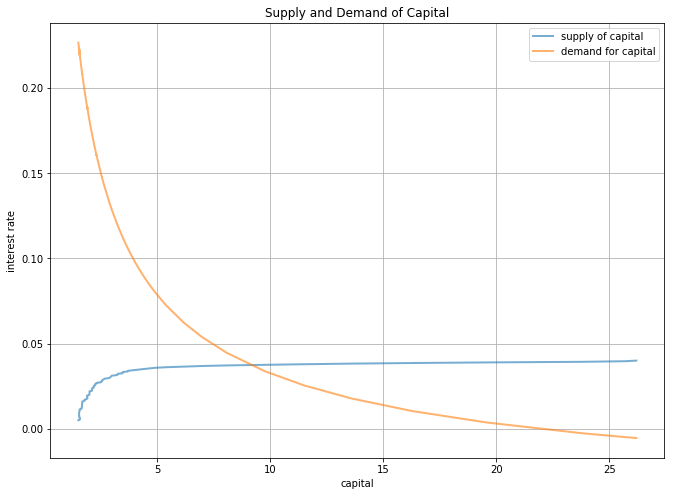

In [12]:
A = 1.0
N = 1.0
α = 0.36
β = 0.96
δ = 0.05


def r_to_w(r):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    return A * (1 - α) * (A * α / (r + δ))**(α / (1 - α))

def rd(K):
    """
    Inverse demand curve for capital.  The interest rate associated with a
    given demand for capital K.
    """
    return A * α * (N / K)**(1 - α) - δ


def prices_to_capital_stock(am, r):
    """
    Map prices to the induced level of capital stock.
    
    Parameters:
    ----------
    
    am : Household
        An instance of an aiyagari_household.Household 
    r : float
        The interest rate
    """
    w = r_to_w(r)
    am.set_prices(r, w)
    aiyagari_ddp = DiscreteDP(am.R, am.Q, β)
    # Compute the optimal policy
    results = aiyagari_ddp.solve(method='policy_iteration')
    # Compute the stationary distribution
    stationary_probs = results.mc.stationary_distributions[0]
    # Extract the marginal distribution for assets
    asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)
    # Return K
    return np.sum(asset_probs * am.a_vals)


# Create an instance of Household
am = Household(a_max=30)

# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.β)

# Create a grid of r values at which to compute demand and supply of capital
num_points = 100
r_vals = np.linspace(0.005, 0.04, num_points)

# Compute supply of capital
k_vals = np.empty(num_points)
for i, r in enumerate(r_vals):
    k_vals[i] = prices_to_capital_stock(am, r)

# Plot against demand for capital by firms
fig, ax = plt.subplots(figsize=(11, 8))
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, label='supply of capital')
ax.plot(k_vals, rd(k_vals), lw=2, alpha=0.6, label='demand for capital')
ax.grid()
ax.set_xlabel('capital')
ax.set_ylabel('interest rate')
ax.legend(loc='upper right')
plt.title("Supply and Demand of Capital")
plt.show()

Text(0.5,1,'Stationary distribution of assets')

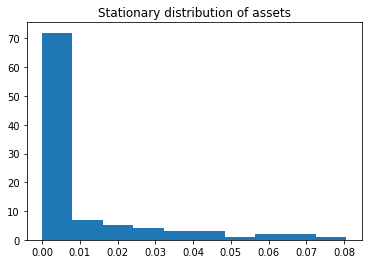

In [13]:
#We need to find the distribution of assets and the stationary distribution
am_ddp = DiscreteDP(am.R, am.Q, am.β)
results = am_ddp.solve(method='policy_iteration')
# Compute the stationary distribution
stationary_probs = results.mc.stationary_distributions[0]
# Extract the marginal distribution for assets
asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)

#PLOT
plt.figure()
plt.hist(asset_probs)
plt.title('Stationary distribution of assets')

In [14]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

gini(asset_probs)

0.7729578591738966